In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot as plt
import copy

In [230]:
person ='Johanna'
survey_file = '/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self.nosync/pipeline/survey_data/pre_processed_survey_features.csv'
survey = pd.read_csv(survey_file)
dates = survey[survey['person']=='Johanna']['date']

# split into train, test  & validation
# First split: 70% training and 30% (validation + test)
train_set, temp_set = train_test_split(dates, test_size=0.25, random_state=42)

# Second split: Split the temp_set into 20% validation and 10% test
val_set, test_set = train_test_split(dates, test_size=1/3, random_state=42)

train_set.shape

(20,)

In [231]:
def load_emg_data(group_set,folder):
    date_string_list = [date.strftime("%Y-%m-%d") for date in group_set]
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".pickle")]
    results = []
    for file in files:
        for prefix in date_string_list:
            if prefix in file:
                results.append(file)
                break  # If a match is found, no need to check other prefixes
    loaded=list()
    for result in results:
        try:
            data = pd.read_pickle(result)[0]
            loaded.append(data)
        except:
            next
        # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded


In [232]:
test_set

10    2024-07-02
15    2024-07-07
11    2024-07-03
31    2024-07-15
0     2024-06-24
13    2024-07-05
21    2024-07-10
23    2024-07-11
14    2024-07-06
Name: date, dtype: object

In [233]:
testy

array([6, 3, 6, 2, 4, 1, 5])

In [234]:
survey_sub = survey[(survey['date']==list(test_set)[8])*(survey['person']=='Johanna')]
# get outcome variable(s)
survey_sub['hooper_fatigue_level'].values[0]

5

In [235]:
def load_dataset_group(group_set,folder_emg,survey_file, person, outcomes):
    #date_string_list = [date.strftime("%Y-%m-%d") for date in group_set]
    # load class output
    survey = pd.read_csv(survey_file)
    loaded = list()
    shapes =list()
    y= list()
    for date in group_set:
        emg_am_name = date + '_AM.pickle'
        emg_pm_name = date + '_PM.pickle'
        try:
            emg_am = pd.read_pickle(folder_emg + emg_am_name)[0]
            print(emg_am_name)
        except:
            emg_am = np.nan
            print("Couldn't load:", emg_am_name)
        try:
            emg_pm = pd.read_pickle(folder_emg + emg_pm_name)[0]
            print(emg_pm_name)

        except:
            emg_pm = np.nan
            print("Couldn't load:", emg_pm_name)
        
        if not isinstance(emg_am, pd.DataFrame):
            #print(emg_pm)
            X_emg = np.hstack([np.full(emg_pm.shape,np.nan), emg_pm])

        if not isinstance(emg_pm, pd.DataFrame):
            print(isinstance(emg_pm, pd.DataFrame))
            print(emg_pm)
            X_emg = np.hstack([emg_am,np.full(emg_am.shape,np.nan)])

        if isinstance(emg_pm, pd.DataFrame) * isinstance(emg_am, pd.DataFrame):
            #emg_am.shape == emg_pm.shape:
            X_emg = np.hstack([emg_am,emg_pm])

        else:
            X_emg = np.full((1,1), np.nan)
        
        shapes.append(X_emg.shape)

        # filter type of set
        survey_sub = survey[(survey['date']==date)*(survey['person']==person)]
        # get outcome variable(s)
        y.append(survey_sub[outcomes].values[0])
        loaded.append(X_emg)
    # get most frequent input shape
    standard_shape = pd.Series(shapes).mode()
    entries_correct = np.array([i for i, x in enumerate(shapes) if x==standard_shape[0]])

    X = np.dstack([loaded[i] for i in entries_correct])
    y = np.array([y[i] for i in entries_correct])
    return X, y


In [293]:

folder_emg = '/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self.nosync/pipeline/data_features/'
person = 'Johanna'
outcomes = 'hooper_fatigue_level'
survey_file = '/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self.nosync/pipeline/survey_data/pre_processed_survey_features.csv'

trainX,trainy =load_dataset_group(train_set,folder_emg,survey_file, person, outcomes)
testX,testy =load_dataset_group(test_set,folder_emg,survey_file, person, outcomes)

Couldn't load: 2024-07-11_AM.pickle
2024-07-11_PM.pickle
2024-07-06_AM.pickle
2024-07-06_PM.pickle
2024-07-18_AM.pickle
2024-07-18_PM.pickle
2024-06-25_AM.pickle
2024-06-25_PM.pickle
2024-06-28_AM.pickle
2024-06-28_PM.pickle
2024-06-29_AM.pickle
2024-06-29_PM.pickle
2024-06-26_AM.pickle
Couldn't load: 2024-06-26_PM.pickle
False
nan
2024-07-09_AM.pickle
2024-07-09_PM.pickle
2024-07-16_AM.pickle
2024-07-16_PM.pickle
2024-06-27_AM.pickle
2024-06-27_PM.pickle
2024-07-19_AM.pickle
2024-07-19_PM.pickle
2024-07-17_AM.pickle
2024-07-17_PM.pickle
2024-07-12_AM.pickle
2024-07-12_PM.pickle
2024-07-20_AM.pickle
2024-07-20_PM.pickle
2024-07-14_AM.pickle
2024-07-14_PM.pickle
2024-07-01_AM.pickle
2024-07-01_PM.pickle
2024-07-04_AM.pickle
2024-07-04_PM.pickle
2024-07-08_AM.pickle
2024-07-08_PM.pickle
2024-07-13_AM.pickle
2024-07-13_PM.pickle
2024-06-30_AM.pickle
2024-06-30_PM.pickle
2024-07-02_AM.pickle
2024-07-02_PM.pickle
2024-07-07_AM.pickle
2024-07-07_PM.pickle
2024-07-03_AM.pickle
2024-07-03_PM.p

In [319]:
testyT = torch.tensor(testy, dtype=torch.float32).reshape(-1, 1)
trainyT = torch.tensor(trainy, dtype=torch.float32).reshape(-1, 1)



# transformation of data into torch tensors
trainXT = torch.from_numpy(trainX)
trainXT = trainXT.transpose(2,0).float() #input is (N, Cin, Lin) = Ntimesteps, Nfeatures, 128
#trainyT = torch.from_numpy(trainy).float()
testXT = torch.from_numpy(testX)
testXT = testXT.transpose(2,0).float()
#testyT = torch.from_numpy(testy).float()
num_epochs = 300
batch_size = 2

 # [samples, time steps, features]
n_timesteps, n_features, n_outputs = trainXT.shape[1], trainXT.shape[2], trainyT.shape[0]
print(n_timesteps)
print(n_features)
print(n_outputs)

# Train the model
total_step = n_outputs

1220
17
18


In [320]:
# define the model using pytorch
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(n_timesteps, 64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(64,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,6),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(6,1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        return out

In [321]:

model = ConvNet1D()
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [322]:

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [328]:
i=0
trainXT_seg = trainXT[i*batch_size:(i+1)*batch_size]
trainyT_seg = trainyT[i*batch_size:(i+1)*batch_size]
# Run the forward pass
outputs = model(trainXT_seg)
#loss = criterion(outputs, torch.max(trainyT_seg, 1)[1])
loss = loss_fn(outputs, trainyT_seg)

In [332]:
trainyT_seg

tensor([[5.],
        [2.]])

In [335]:
((0.0336-5)**2+(0.0336-2)**2)/2

14.26592896

In [333]:
loss

tensor(14.2661, grad_fn=<MseLossBackward0>)

In [330]:
lo

tensor([[0.0336],
        [0.0336]], grad_fn=<AddmmBackward0>)

tensor(14.2661, grad_fn=<MseLossBackward0>)
tensor(25.6651, grad_fn=<MseLossBackward0>)
tensor(9.7994, grad_fn=<MseLossBackward0>)
tensor(9.7992, grad_fn=<MseLossBackward0>)
tensor(9.7991, grad_fn=<MseLossBackward0>)
tensor(16.7316, grad_fn=<MseLossBackward0>)
tensor(24.6640, grad_fn=<MseLossBackward0>)
tensor(20.1975, grad_fn=<MseLossBackward0>)
tensor(30.1298, grad_fn=<MseLossBackward0>)
tensor(14.2647, grad_fn=<MseLossBackward0>)
tensor(25.6631, grad_fn=<MseLossBackward0>)
tensor(9.7982, grad_fn=<MseLossBackward0>)
tensor(9.7980, grad_fn=<MseLossBackward0>)
tensor(9.7979, grad_fn=<MseLossBackward0>)
tensor(16.7300, grad_fn=<MseLossBackward0>)
tensor(24.6620, grad_fn=<MseLossBackward0>)
tensor(20.1957, grad_fn=<MseLossBackward0>)
tensor(30.1276, grad_fn=<MseLossBackward0>)
tensor(14.2633, grad_fn=<MseLossBackward0>)
tensor(25.6611, grad_fn=<MseLossBackward0>)
tensor(9.7970, grad_fn=<MseLossBackward0>)
tensor(9.7968, grad_fn=<MseLossBackward0>)
tensor(9.7967, grad_fn=<MseLossBackward0

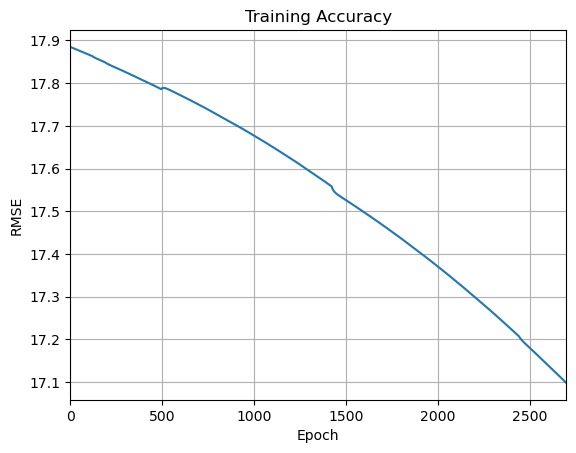

In [336]:

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))): # split data into batches
    #with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
       # print(i)
        model.train()
        #bar.set_description(f"Epoch {epoch}")
        #for start in bar:
        trainXT_seg = trainXT[i*batch_size:(i+1)*batch_size]
        trainyT_seg = trainyT[i*batch_size:(i+1)*batch_size]
        # Run the forward pass
        outputs = model(trainXT_seg)
        #loss = criterion(outputs, torch.max(trainyT_seg, 1)[1])
        loss = loss_fn(outputs, trainyT_seg)
        print(loss)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print progress
        #bar.set_postfix(mse=float(loss))

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(testXT)
        mse = loss_fn(y_pred, testyT)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
     #loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()
        # Track the accuracy
        #total = trainyT_seg.size(0)
        #_, predicted = torch.max(outputs, 1)
        #_, actual = torch.max(trainyT_seg, 1)
       # correct = (predicted == actual).sum().item()
       # correct_sum = correct_sum + (correct/total)
       #acc_list.append(correct / total)
    #print("Epoch")
    #print(epoch)
    #print("accuracy")
    #print(correct_sum/int(np.floor(total_step/batch_size)))
    #acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))
# restore model and return best accuracy
model.load_state_dict(best_weights)
#plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(history)
plt.show()

MSE: 17.88
RMSE: 4.23


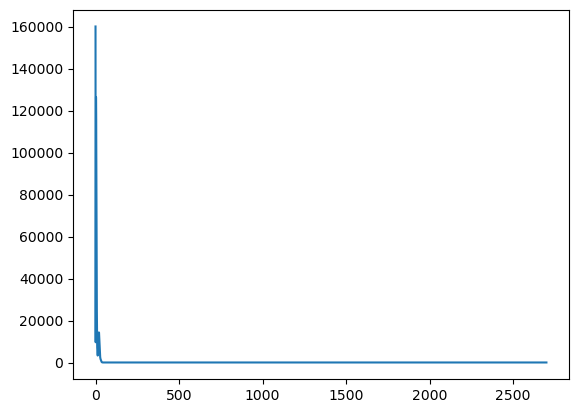

In [324]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()